<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson6_MD_simulation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade asap3
!pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.7 MB/s eta 0:00:00
  Created wheel for asap3: filename=asap3-3.13.5-cp310-cp310-linux_x86_64.whl size=5290729 sha256=44691d7f555dd8dd9b28990f9630fd0d463285d71145efeee8a83d54f880e834
  Stored in directory: /root/.cache/pip/wheels/46/ea/c9/a4842193d4c8b95860e8e90e490540e2a15f440af955ed62fc
Successfully built asap3


In [2]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (1,822 kB/s)
debconf: unable to initialize frontend: Dialo

In [3]:
import os
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))


Atoms(symbols='Cu256', pbc=True, cell=[14.44, 14.44, 14.44])


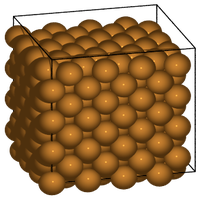

In [71]:
import os
from asap3 import EMT
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

calculator = EMT()
# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 4
atoms_in.pbc = True
print(atoms_in)
visual(atoms_in)

In [72]:
import numpy as np
from ase import units
from ase.md.npt import NPT
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from time import perf_counter


def print_dyn(dyn, atoms, start_time):
    """Print dynamics information: step, total energy, temperature, stress, and elapsed time."""
    imd = dyn.get_number_of_steps()
    etot = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True) / units.GPa
    stress_ave = (stress[0] + stress[1] + stress[2]) / 3.0
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}   {elapsed_time:.3f}")


def run_md(atoms, calculator, time_step, temperature, sigma, ttime, pfactor, num_md_steps, num_interval, output_filename):
    """
    Set up and run an MD simulation for the provided atoms with specified conditions.
    """
    calculator = EMT()
    atoms.calc = calculator
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature, force_temp=True)
    Stationary(atoms)

    positions = []  # To store atom positions at each interval
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"

    dyn = NPT(atoms,
              time_step * units.fs,
              temperature_K=temperature,
              externalstress=sigma * units.bar,
              ttime=ttime * units.fs,
              pfactor=pfactor * units.GPa * (units.fs**2),
              logfile=log_filename,
              trajectory=traj_filename,
              loginterval=num_interval
              )

    # Attach logging and store positions
    print("  imd   etot   temp_K   stress_ave   elapsed_time")

    global start_time
    start_time = perf_counter()
    dyn.attach(lambda: positions.append(atoms.get_positions()), interval=num_interval)
    dyn.attach(lambda: print_dyn(dyn, atoms, start_time), interval=num_interval)
    dyn.run(num_md_steps)

    return np.array(positions)

# Example of running the simulations externally in a loop
time_step = 1.0  # fsec
num_md_steps = 1000  # 10ps, increase for more equilibration
num_interval = 100
sigma = 1.0  # External pressure in bar
ttime = 20.0  # Time constant in fs
pfactor = 2e6  # Barostat parameter in GPa*fs^2
temperature = 300  # Room temperature in K

for i in range(3):
    output_filename = f"./{temperature}K_sim_{i+1}"
    run_md(atoms_in, calculator, time_step, temperature, sigma, ttime, pfactor, num_md_steps, num_interval, output_filename)

  imd   etot   temp_K   stress_ave   elapsed_time
  100   29.698    182.80    -2.89   0.240
  200   16.470    298.10    2.35   0.475
  300   21.341    292.63    0.31   0.732
  400   19.300    278.19    -1.42   0.967
  500   17.648    289.89    -0.73   1.213
  600   20.886    296.93    0.54   1.452
  700   20.907    305.75    1.35   1.678
  800   18.902    287.14    0.01   1.940
  900   18.581    291.65    -1.48   2.179
  1000   19.705    279.32    -0.68   2.427
  imd   etot   temp_K   stress_ave   elapsed_time
  100   17.666    290.13    0.23   0.234
  200   21.686    298.29    -0.01   0.483
  300   19.424    302.70    0.46   0.715
  400   20.756    316.74    -0.34   0.952
  500   18.435    295.41    -0.22   1.183
  600   20.179    292.71    -0.18   1.451
  700   19.575    299.66    0.61   1.682
  800   18.641    272.56    0.26   1.924
  900   20.472    299.55    -0.64   2.167
  1000   18.286    294.08    -0.04   2.408
  imd   etot   temp_K   stress_ave   elapsed_time
  100   21.180   

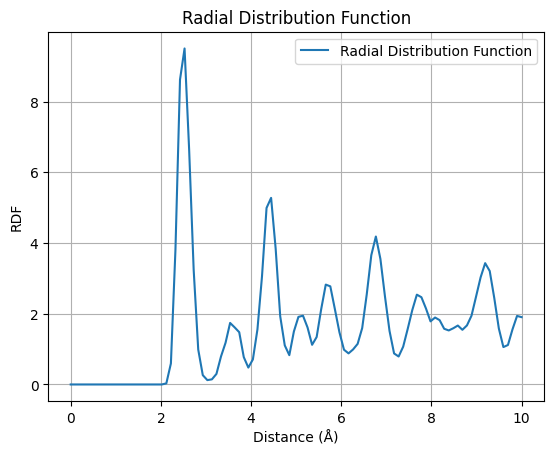

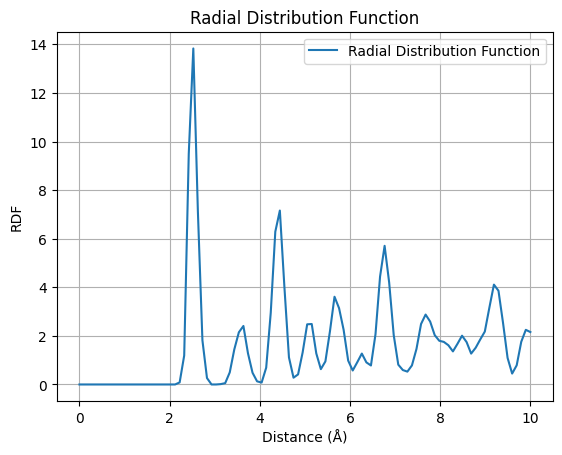

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ase.neighborlist import NeighborList
from ase.io import Trajectory

def radial_distribution_function(atoms, r_max, bin_size, plot=True):
    """
    Calculate and plot the radial distribution function (RDF) of a system of atoms.

    Parameters:
    atoms: ASE Atoms object
        The atomic system for which to calculate the RDF.
    r_max: float
        The maximum radius to consider for the RDF (in angstroms).
    bin_size: float
        The size of the distance bins (in angstroms).
    """

    num_atoms = len(atoms)

    volume = atoms.get_volume()  # System volume in Angstrom^3
    density = num_atoms / volume  # Number density in atoms/Angstrom^3

    # Create an array of bins for the distances
    num_bins = int(r_max / bin_size)
    rdf = np.zeros(num_bins)
    r = np.linspace(0, r_max, num_bins)

    # Neighbor list to find close atoms
    cutoffs = [r_max / 2.0] * num_atoms
    neighbor_list = NeighborList(cutoffs=cutoffs, self_interaction=False, bothways=True)
    neighbor_list.update(atoms)

    # Loop over all atoms and calculate distances
    positions = atoms.get_positions()
    for i in range(num_atoms):
        indices, offsets = neighbor_list.get_neighbors(i)
        for j, offset in zip(indices, offsets):
            # Calculate distance manually
            delta_pos = positions[i] - (positions[j] + np.dot(offset, atoms.get_cell()))
            distance_ij = np.linalg.norm(delta_pos)
            if distance_ij < r_max:
                bin_index = int(distance_ij / bin_size)
                rdf[bin_index] += 2  # Counting both atoms in the pair

    for i in range(num_bins):
        shell_volume = 4.0 / 3.0 * np.pi * ((r[i] + bin_size)**3 - r[i]**3)
        rdf[i] /= num_atoms * density * shell_volume

    if plot:
        plt.figure()
        plt.plot(r, rdf, label='Radial Distribution Function')
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title('Radial Distribution Function')
        plt.grid(True)
        plt.legend()
        plt.show()

    return r, rdf

r_max = 10.0  # Maximum distance (in angstroms)
bin_size = 0.1  # Bin size (in angstroms)


traj=Trajectory('./300K_sim_1.traj')
r, rdf = radial_distribution_function(traj[0], r_max, bin_size)
r, rdf = radial_distribution_function(traj[-1], r_max, bin_size)


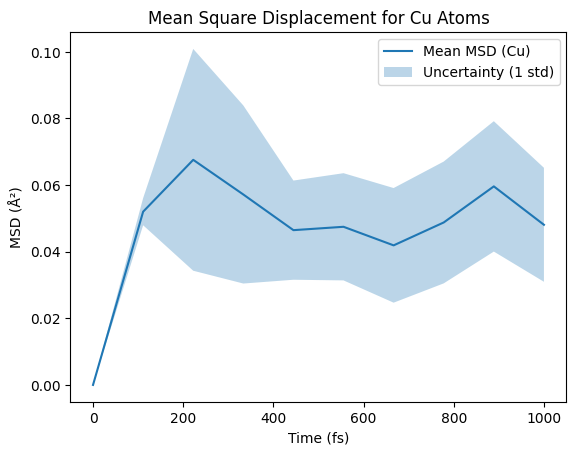

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import Trajectory
from ase import Atoms

def calculate_msd(positions, reference_positions):
    """Compute MSD for all atoms at each time step."""
    displacements = positions - reference_positions
    squared_displacements = np.sum(displacements**2, axis=2)  # sum over x, y, z
    msd = np.mean(squared_displacements, axis=1)  # mean over all atoms
    return msd

def get_atom_positions(traj, atom_type):
    """Extract the positions of a specific atom type from a trajectory."""
    positions = []
    for atoms in traj:
        atoms_positions=[]
        for atom in atoms:
          if atom.symbol == atom_type:
            atoms_positions.append(atom.position)
        positions.append(atoms_positions)
    return np.array(positions)

def plot_msd_with_std(time_steps, msds, stds, atom_type):
    """Plot the MSD with standard deviation using fill_between."""


# Input parameters for the simulation
time_step = 1.0  # fsec
num_md_steps = 1000  # total MD steps
num_interval = 100
num_msd_points = num_md_steps // num_interval  # Number of MSD points to calculate
time_steps = np.linspace(0, time_step * num_md_steps, num_msd_points)
msds_all_runs = []

for i in range(3):
    traj = Trajectory(f'./300K_sim_{i+1}.traj')
    positions = get_atom_positions(traj, 'Cu')
    reference_positions = positions[0]
    msd = calculate_msd(positions, reference_positions)
    msds_all_runs.append(msd)

msds_all_runs = np.array(msds_all_runs)
mean_msd = np.mean(msds_all_runs, axis=0)
std_msd = np.std(msds_all_runs, axis=0)
plt.figure()
plt.plot(time_steps, mean_msd, label=f'Mean MSD (Cu)')
plt.fill_between(time_steps, mean_msd - std_msd, mean_msd + std_msd, alpha=0.3, label=f'Uncertainty (1 std)')
plt.xlabel('Time (fs)')
plt.ylabel('MSD (Å²)')
plt.title(f'Mean Square Displacement for Cu Atoms')
plt.legend()
plt.show()

# Displacement of Pt atoms on Au

Cell([[17.309974003446687, 0.0, 0.0], [8.654987001723343, 14.99087722583305, 0.0], [0.0, 0.0, 27.066767294881018]])


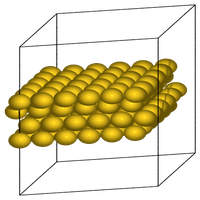

In [8]:
from ase.build import fcc111
slab = fcc111('Au', size=(6,6,4), vacuum=10.0)
print(slab.cell)
visual(slab)

In [79]:
import numpy as np
from ase import units
from ase.md.nvtberendsen import NVTBerendsen  # NVT ensemble with Berendsen thermostat
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from time import perf_counter

def print_dyn(dyn, atoms, start_time):
    """Print dynamics information: step, total energy, temperature, and elapsed time."""
    imd = dyn.get_number_of_steps()
    etot = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}   {elapsed_time:.3f}")

def run_md_nvt(atoms, calculator, time_step, temperature, num_md_steps, num_interval, output_filename):
    """
    Set up and run an MD simulation in NVT ensemble for the provided atoms with specified conditions.
    """
    # Set up the calculator (EMT in this case)
    calculator = EMT()
    atoms.calc = calculator

    # Set up the initial temperature distribution
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature, force_temp=True)
    Stationary(atoms)

    positions = []  # To store atom positions at each interval
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"

    # Set up NVT ensemble using the Berendsen thermostat
    dyn = NVTBerendsen(atoms,
                       time_step * units.fs,
                       temperature_K=temperature,
                       taut=100.0 * units.fs,  # Temperature coupling constant
                       logfile=log_filename,
                       trajectory=traj_filename,
                       loginterval=num_interval
                       )

    # Attach logging and store positions
    print("  imd   etot   temp_K   elapsed_time")

    global start_time
    start_time = perf_counter()
    dyn.attach(lambda: positions.append(atoms.get_positions()), interval=num_interval)
    dyn.attach(lambda: print_dyn(dyn, atoms, start_time), interval=num_interval)
    dyn.run(num_md_steps)

    return np.array(positions)

# Example of running the simulations externally in a loop
time_step = 1.0  # fsec
num_md_steps = 100000  # 100ps, increase for more equilibration
num_interval = 5000 # 5 ps
temperature = 300  # Room temperature in K



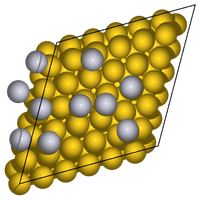

  imd   etot   temp_K   elapsed_time
    0   44.575    300.00   0.004
  5000   34.631    293.98   2.244
  10000   34.186    311.63   4.548
  15000   34.322    306.02   7.908
  20000   34.181    312.20   10.153
  25000   34.055    313.92   12.346
  30000   34.316    314.90   14.573
  35000   34.088    301.18   16.773
  40000   34.132    300.49   19.662
  45000   34.246    291.61   22.474
  50000   34.031    290.06   24.700
  55000   34.060    325.58   26.919
  60000   34.021    289.51   29.175
  65000   34.144    308.97   31.518
  70000   34.164    300.58   36.402
  75000   34.281    311.52   39.215
  80000   34.196    289.16   42.955
  85000   34.079    303.73   46.623
  90000   34.100    303.02   51.173
  95000   34.025    295.26   55.946
  100000   33.995    290.47   61.222


array([[[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+01],
        [ 2.88499567e+00,  0.00000000e+00,  1.00000000e+01],
        [ 5.76999133e+00,  0.00000000e+00,  1.00000000e+01],
        ...,
        [ 4.82027113e+00,  7.94771789e+00,  1.90667673e+01],
        [ 9.51891391e+00,  7.03431496e+00,  1.90667673e+01],
        [ 2.67586532e+00,  1.05827716e+01,  1.90667673e+01]],

       [[-7.11264966e-02, -2.13993191e-01,  1.00281304e+01],
        [ 3.03341400e+00, -1.26028457e-02,  9.97185663e+00],
        [ 5.81504063e+00, -1.05515263e-02,  9.92083096e+00],
        ...,
        [ 5.99681192e+00,  1.21688644e+01,  1.92352901e+01],
        [ 1.17864746e+01,  8.48075771e+00,  1.90686215e+01],
        [ 4.62516910e+00,  1.43232188e+01,  1.92083484e+01]],

       [[ 6.57075352e-02, -2.39923372e-02,  9.91213248e+00],
        [ 2.87316457e+00, -1.08095418e-01,  1.00291150e+01],
        [ 5.75891413e+00,  4.47785997e-02,  1.00058084e+01],
        ...,
        [ 5.71257033e+00,  1.16771774e+01,

In [80]:
import numpy as np
from ase.build import fcc111
from ase import Atoms
from scipy.spatial.distance import pdist

def place_random_pt_atoms(slab, num_pt_atoms=10, tolerance=3.0, z_offset=2.0, max_attempts=1000, boundary_margin=1.0):
    """
    Place random Pt atoms on top of the slab within a reduced cell, ensuring they are not too close to the boundaries.

    Parameters:
    slab: ASE Atoms object
        The slab on which Pt atoms will be placed.
    num_pt_atoms: int
        Number of Pt atoms to place.
    tolerance: float
        Minimum distance between Pt atoms.
    z_offset: float
        The distance above the slab to place the Pt atoms.
    max_attempts: int
        Maximum number of attempts to place the atoms.
    boundary_margin: float
        The amount to shrink the cell by on both X and Y dimensions.
    """
    temp = slab.copy()
    z_position = max(temp.positions[:, 2]) + z_offset  # Z position above the slab

    # Reduce the size of the slab's X and Y dimensions by `boundary_margin`
    x_min, x_max = boundary_margin, slab.cell[0, 0] - boundary_margin
    y_min, y_max = boundary_margin, slab.cell[1, 1] - boundary_margin

    # List to store positions of Pt atoms in Cartesian space
    pt_positions_cartesian = []

    # Function to check if newly added Pt atom satisfies distance constraint
    def is_valid_position(new_position, existing_positions, tol):
        if not existing_positions:
            return True
        all_positions = np.array(existing_positions + [new_position])
        distances = pdist(all_positions[:, :2])  # Only check distances in the X-Y plane
        return np.all(distances >= tol)

    # Randomly place Pt atoms with distance tolerance using reduced cell size
    attempts = 0
    while len(pt_positions_cartesian) < num_pt_atoms and attempts < max_attempts:
        # Generate random coordinates within the reduced cell
        new_x = np.random.uniform(x_min, x_max)
        new_y = np.random.uniform(y_min, y_max)

        # Create a new position above the slab
        cartesian_position = [new_x, new_y, z_position]

        # Check if the position satisfies the distance tolerance
        if is_valid_position(cartesian_position, pt_positions_cartesian, tolerance):
            pt_positions_cartesian.append(cartesian_position)

        attempts += 1

    # Check if placement was successful
    if len(pt_positions_cartesian) != num_pt_atoms:
        raise ValueError(f"Failed to place {num_pt_atoms} Pt atoms with a tolerance of {tolerance} Å after {attempts} attempts.")

    # Step 3: Create Pt atoms and add them to the slab
    pt_atoms = Atoms('Pt{}'.format(num_pt_atoms), positions=pt_positions_cartesian)
    combined_slab = temp + pt_atoms
    return combined_slab

# Example usage
slab = fcc111('Au', size=(6, 6, 4), vacuum=10.0)
combined_slab = place_random_pt_atoms(slab, num_pt_atoms=10, tolerance=3.0, z_offset=2.0, boundary_margin=1.0)

visual(combined_slab, rotation='15z,-0x')
run_md_nvt(combined_slab, calculator, time_step, temperature, num_md_steps, num_interval, 'test')

Lets make a video

In [57]:
!pip install Pillow

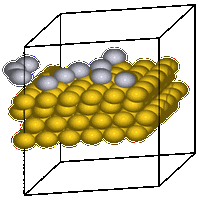

In [69]:
import os
import shutil
import glob
import contextlib
from PIL import Image
from ase.io import write
from IPython.display import display, Image as IPImage

def visual4gif(structure, file_name, max_size=(200, 200), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)
    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)

    # Save the image with the enumerated file name
    img.save(os.path.join(png_save_path, file_name))

    # Clean up temporary files
    files = ['./temp.ini', './temp.pov', './temp.png']
    for file in files:
        if os.path.isfile(file):
            os.remove(file)

def png_to_gif(png_dir, gif_path, duration=200):
    # Find all PNG files in the directory
    png_files = sorted(glob.glob(os.path.join(png_dir, "frame*")))
    if not png_files:
        raise ValueError(f"No PNG files found in the directory: {png_dir}")
    with contextlib.ExitStack() as stack:
        imgs = [stack.enter_context(Image.open(png)) for png in png_files]
        first_img = imgs[0]
        first_img.save(fp=gif_path, format='GIF', append_images=imgs[1:],
                       save_all=True, duration=duration, loop=0)
    display(IPImage(filename=gif_path))

def visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200):
    os.makedirs(png_save_path, exist_ok=True)
    for i, atoms in enumerate(trajectory):
        file_name = f"frame_{i:02d}.png"  # Use 4 digits for frame numbering
        visual4gif(atoms, file_name, png_save_path=png_save_path)
    png_to_gif(png_save_path, gif_path, duration)


trajectory = Trajectory("./test.traj")
visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200)


Get MSD of Pt

In [65]:
time_step = 1.0  # fsec
num_md_steps = 100  # total MD steps
num_interval = 10
for i in range(3):
    output_filename = f"./{temperature}K_PtAu_{i+1}"
    combined_slab = place_random_pt_atoms(slab, num_pt_atoms=10, tolerance=3.0, z_offset=2.0)
    #visual(combined_slab, rotation='15z,-0x')
    run_md_nvt(combined_slab, calculator, time_step, temperature, num_md_steps, num_interval, output_filename)

  imd   etot   temp_K   elapsed_time
    0   42.724    300.00   0.124
   10   42.642    423.37   0.416
   20   42.257    551.21   0.662
   30   41.757    530.48   0.933
   40   41.378    435.50   1.273
   50   41.203    332.92   1.573
   60   41.214    253.94   1.819
   70   41.350    210.80   2.068
   80   41.539    204.39   2.322
   90   41.713    226.55   2.666
  100   41.828    262.90   2.916
  imd   etot   temp_K   elapsed_time
    0   44.916    300.00   0.107
   10   44.802    463.97   0.381
   20   44.302    621.23   0.764
   30   43.663    596.32   1.125
   40   43.168    485.28   1.745
   50   42.908    367.59   2.406
   60   42.859    278.74   3.087
   70   42.951    231.57   4.113
   80   43.099    226.19   5.167
   90   43.225    254.61   7.329
  100   43.273    304.01   8.887
  imd   etot   temp_K   elapsed_time
    0   51.546    300.00   0.233
   10   51.317    613.87   1.203
   20   50.392    883.33   2.174
   30   49.238    836.22   3.286
   40   48.327    654.42   4.29

get MSD

[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]


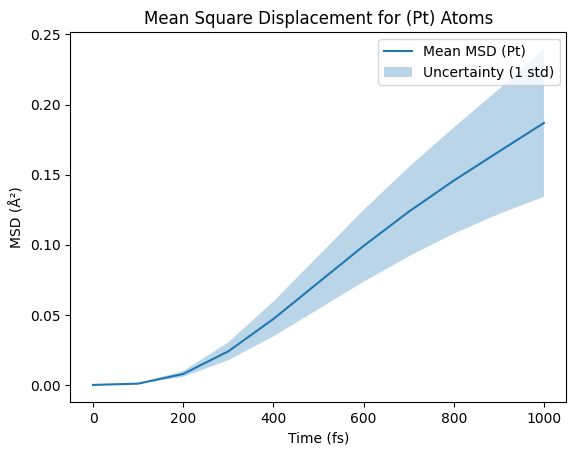

In [82]:
num_msd_points = num_md_steps // num_interval  # Number of MSD points to calculate
time_steps = np.linspace(0, time_step * num_md_steps, num_msd_points+1)
print(time_steps)
msds_all_runs = []
element_of_interest='Pt'
for i in range(3):
    traj = Trajectory(f'./300K_PtAu_{i+1}.traj')
    positions = get_atom_positions(traj, element_of_interest)
    reference_positions = positions[0]
    msd = calculate_msd(positions, reference_positions)
    msds_all_runs.append(msd)

msds_all_runs = np.array(msds_all_runs)
mean_msd = np.mean(msds_all_runs, axis=0)
std_msd = np.std(msds_all_runs, axis=0)
plt.figure()
plt.plot(time_steps, mean_msd, label=f'Mean MSD ({element_of_interest})')
plt.fill_between(time_steps, mean_msd - std_msd, mean_msd + std_msd, alpha=0.3, label=f'Uncertainty (1 std)')
plt.xlabel('Time (fs)')
plt.ylabel('MSD (Å²)')
plt.title(f'Mean Square Displacement for ({element_of_interest}) Atoms')
plt.legend()
plt.show()